In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subtractr
import subtractr.utils as util
import os

/home/ba2617/.conda/envs/opsin_subtraction_experiments/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Spatial cell estimation
1. Load results after running photocurrent subtraction + demixing + caviar
2. use the average photocurrent estimates to estimate the patched cell location 

In [ ]:
example_path = '/home/ba2617/mbcs_grids/scripts/220308_B6_Chrome2fGC8_030822_Cell1_OpsPositive_A_planes_cmReformat_with_nws_results.npz'
results = np.load(example_path, allow_pickle=True)
results = util.sort_results(results)

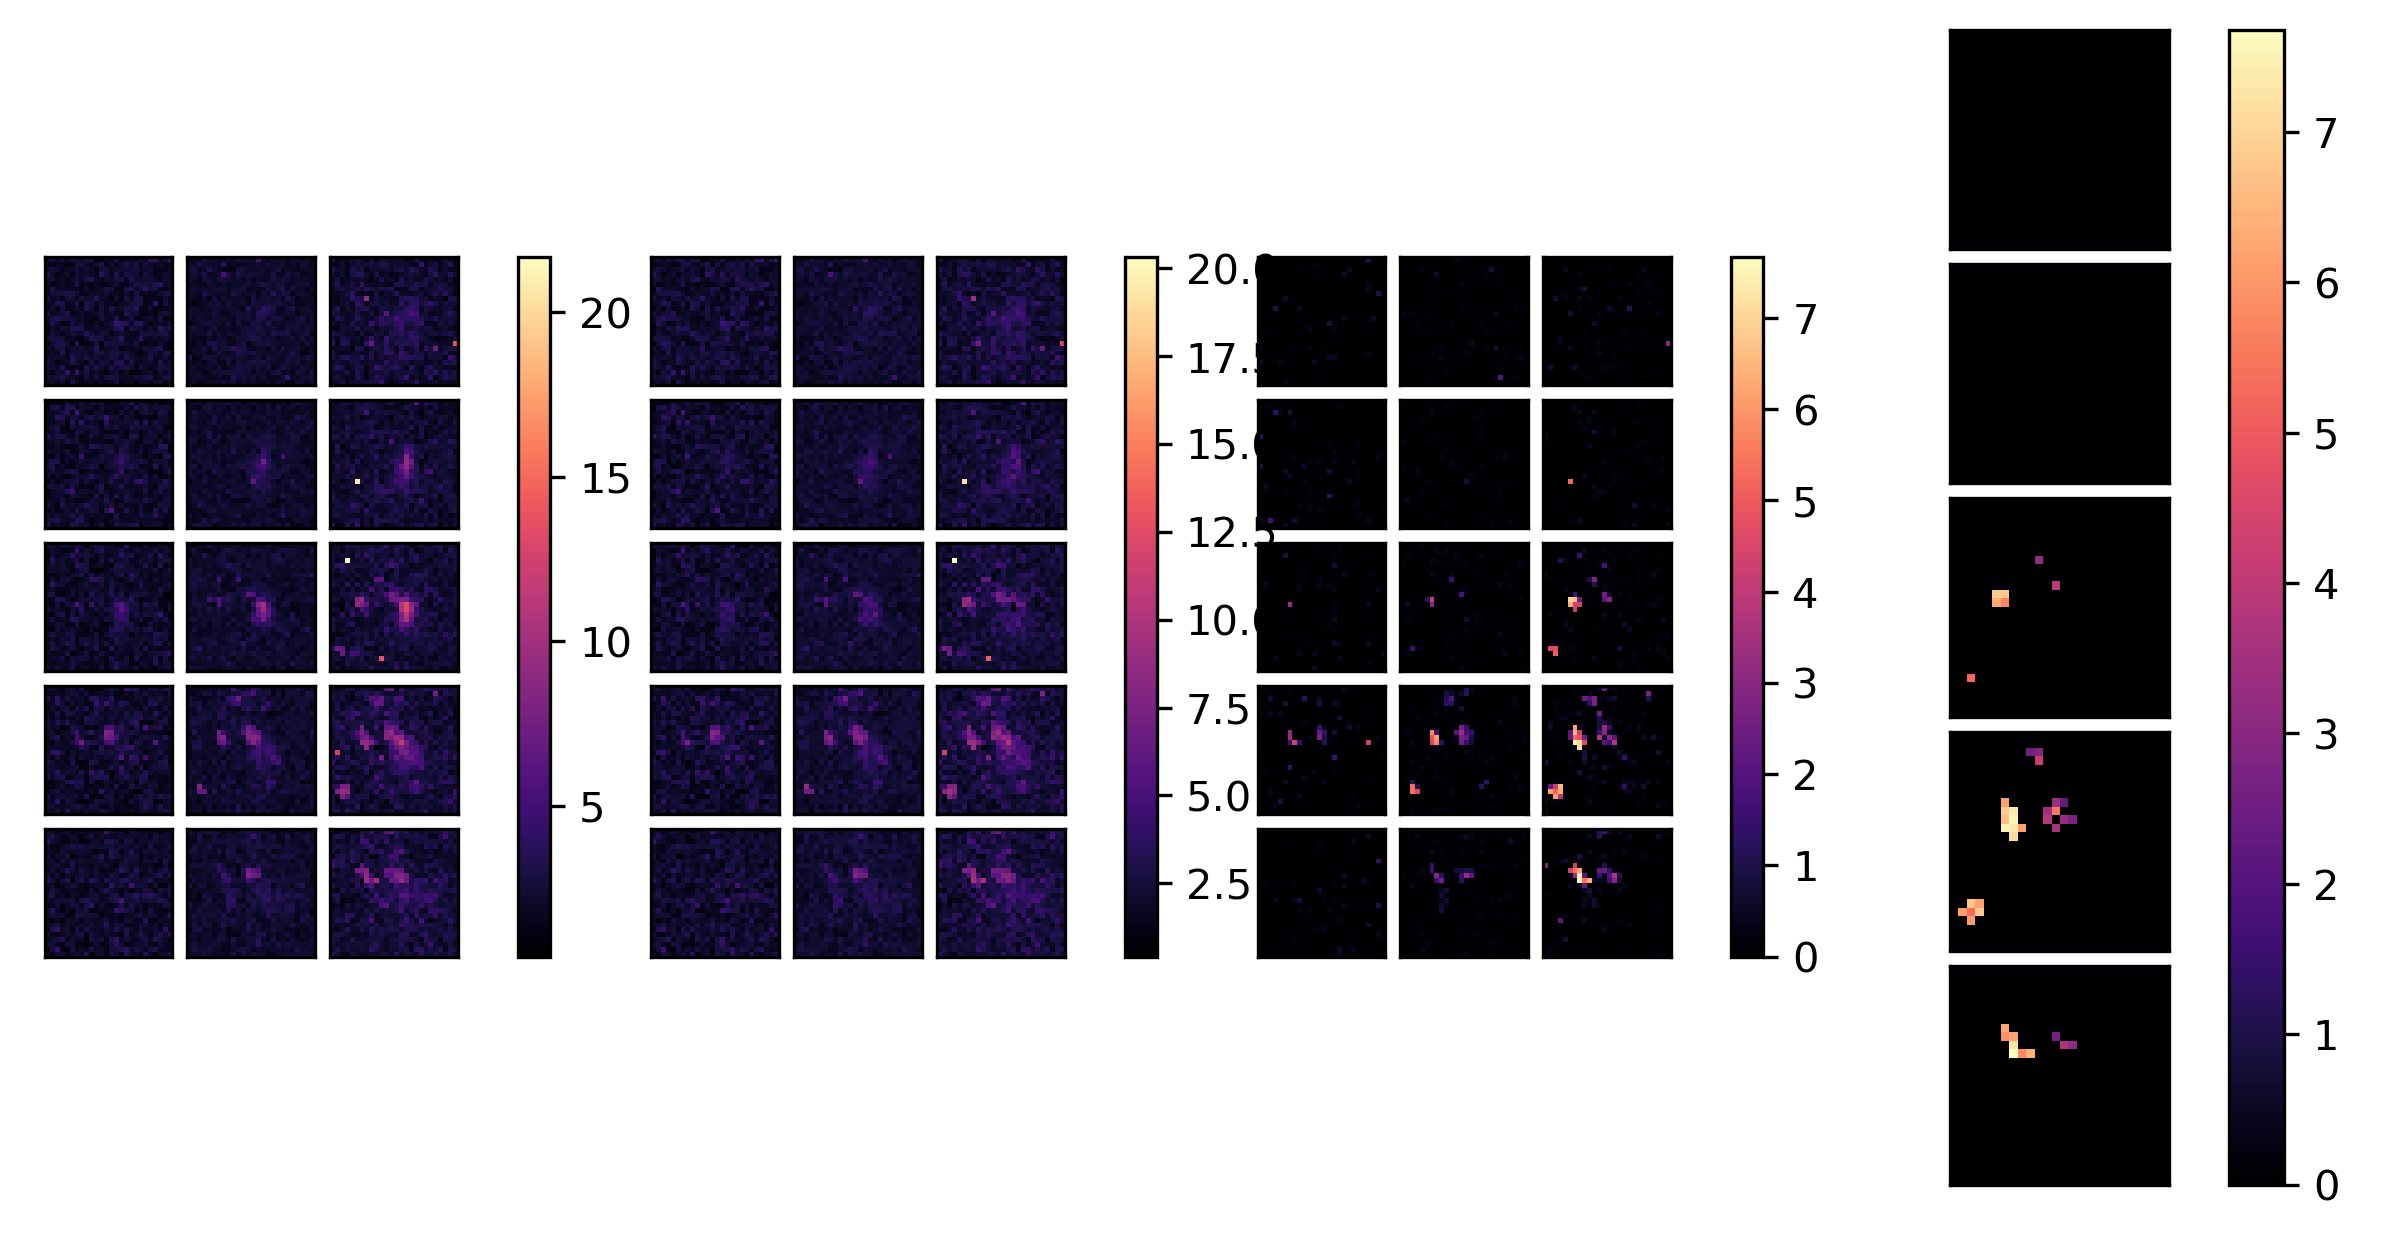

In [4]:
fig = plt.figure(figsize=(10,5), dpi=300)
est_map = util.traces_tensor_to_map(results['est_tensor'])
weights_map = results['model_state']['mu'].reshape(1, *est_map.shape[1:])
util.plot_multi_means(
    fig,
    [results['raw_map'], results['subtracted_map'], results['demixed_map'], weights_map],
    np.arange(5),
    cmaps=['magma', 'magma', 'magma', 'magma'],
)


In [43]:
est_map.shape[1:]

(26, 26, 5)

## Aggregate across experiments
for each experiment
    1. compute center of mass
    3. convert center of mass to imaging coordinates from index coordinates
    2. subtract center of mass from targets
    
output data structure which is a dictionary:
```
{
    filepath: {
        'targets': targets,
        'com': estimated_com in imaging coordinates
        'weights': caviar weights
        'raw obs': average observation (before subtraction + demixing) at that pixel
        }
}
```

In [9]:
from scipy import ndimage

In [18]:
filenames = [
'220308_B6_Chrome2fGC8_030822_Cell1_OpsPositive_A_planes_cmReformat_with_nws_results.npz',
'220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_planes_cmReformat_with_nws_results.npz',
'220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell3_opsPositive_A_planes_cmReformat_with_nws_results.npz',
'220617_B6_Chrome2fGC8_IC_061722_Cell1_C_planes_cmReformat_with_nws_results.npz',
'220704_B6_Chrome2fGC8_IC_070422_Cell1_Control_A_planes_cmReformat_with_nws_results.npz',
]

top_level_path = '../scripts/'

def index_coords_to_image_coords(index_pt, targets):
    '''
    Converts a point in pixel coordinates to um
    '''

    # conversion from index coords to image coords
    # is a linear transform img_x = a*idx_x + b
    # We perform the same transform for x,y,z
    img_pt = np.zeros_like(index_pt)
    for i, coord in enumerate(index_pt):
        unique_tars = np.unique(targets[:,i])
        b = unique_tars[0]
        
        # handle the case where there is only a single z plane
        if len(unique_tars) == 1:
            a = 0
        else:
            a = unique_tars[1] - unique_tars[0]
        img_pt[i] = a*coord + b

    return img_pt



In [ ]:
aggregated_results = {}
for file in filenames:
    loadpath = os.path.join(top_level_path, file)
    results = np.load(loadpath, allow_pickle=True)
    results = util.sort_results(results)
    est_map = util.traces_tensor_to_map(results['est_tensor'])

    com_index = ndimage.center_of_mass(est_map[-1,...])
    com_image = index_coords_to_image_coords(com_index, results['targets'])
    
    aligned_targets = results['targets'] - com_image
    weights = results['model_state']['mu']
    
    aggregated_results[os.path.basename(file)] = dict(
        com_image = com_image,
        aligned_targets = aligned_targets,
        weights = weights,
    )
    
    

(3380, 3)
(3380, 3)
(676, 3)
